Отчёт исключительно для иллюстрации, то есть, когда я пишу "очевидно что" или "видна закономерность" это значит, что в действительности всё проверялось на большем числе примеров, но перегружать файл я не хочу.

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, normalized_mutual_info_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from mlxtend.classifier import StackingClassifier
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [67]:
train = pd.DataFrame.from_csv('train.tsv')
#train = train.sample(frac=0.01, random_state=3)

target = train['y']
train = train.drop(['y'], axis=1)

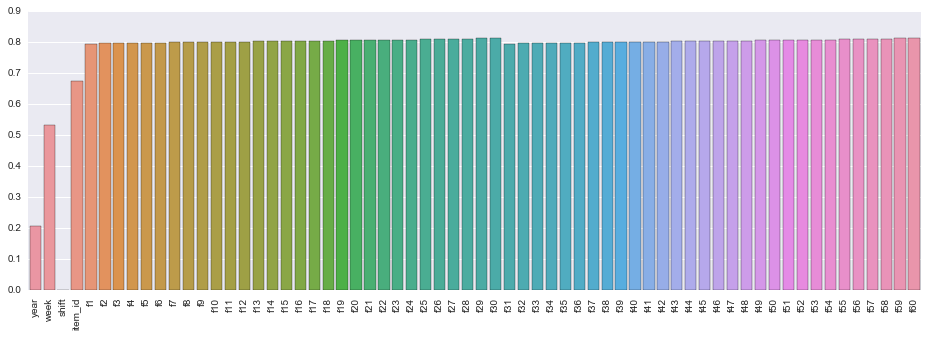

In [68]:
plt.figure(figsize=(16, 5))
sns.barplot(train.columns, [normalized_mutual_info_score(train[c], target) for c in train.columns])
_ = plt.xticks(rotation=90)

Видно, что график сдвинут на 30, то есть значения f\_x совпадает с значением f_\(x+30) из чего можно сделать вывод, что признаки одинаковые.

In [8]:
train['f9'][:3]

Num
0    48325.0
1    24780.0
2    87478.0
Name: f9, dtype: float64

In [9]:
train['f39'][:3]

Num
0    48325.0
1    24780.0
2    87478.0
Name: f39, dtype: float64

In [69]:
train['y'] = target

Также видно, что сильнее всего на ответ влияет f60, посмотрим подробнее.

В переменной shift указано, на сколько недель значения признаков отстают от недели, записанной в week, используем эту информацию, выберем произвольный item_id.

In [48]:
train.loc[(train['year']==2013) & (train['week'] == 4)][:4]

,year,week,shift,item_id,f1,f2,f3,f4,f5,f6,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,y
Num,,,,,,,,,,,,,,,,,,,,,
7395,2013,4,3,20441582,370.0,140.0,1202.0,130.0,70.0,125.0,...,135.0,158.0,91.0,200.0,140.0,100.0,110.0,360.0,100.0,402
7396,2013,4,3,20442214,2740.0,3329.0,6601.0,2797.0,5782.0,3154.0,...,2630.0,2190.0,1690.0,3330.0,1770.0,2280.0,2951.0,6870.0,1080.0,3397
7397,2013,4,3,20441583,70.0,50.0,1288.0,35.0,15.0,70.0,...,70.0,120.0,45.0,190.0,80.0,80.0,85.0,275.0,30.0,104
7398,2013,4,3,20441584,70.0,115.0,1085.0,65.0,65.0,60.0,...,130.0,180.0,131.0,190.0,140.0,93.0,130.0,365.0,70.0,177


In [53]:
A = train.loc[(train['item_id'] == 20441582) & (train['week']==4+3)]

In [54]:
A

,year,week,shift,item_id,f1,f2,f3,f4,f5,f6,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,y
Num,,,,,,,,,,,,,,,,,,,,,
17830,2013,7,3,20441582,130.0,70.0,125.0,115.0,250.0,138.0,...,200.0,140.0,100.0,110.0,360.0,100.0,30.0,75.0,250.0,96
21051,2013,7,2,20441582,70.0,125.0,115.0,250.0,138.0,90.0,...,140.0,100.0,110.0,360.0,100.0,30.0,75.0,250.0,215.0,96
24268,2013,7,1,20441582,125.0,115.0,250.0,138.0,90.0,315.0,...,100.0,110.0,360.0,100.0,30.0,75.0,250.0,215.0,115.0,96


Видно, что ряды признаков f1..f60 сдвинуты друг относительно друга, вообще, все эти признаки скорее всего детерминированно связаны друг с другом, поэтому нет смысла рассматривать все из них, достаточно смотреть на f60, так как он больше остальных влияет на результат.

In [71]:
cols = ['year', 'week', 'shift', 'item_id', 'f60', 'y']
train = train[cols]

In [72]:
train[:5]

,year,week,shift,item_id,f60,y
Num,,,,,,
0,2012,52,1,20442076,45239.0,123438
1,2012,52,1,20441997,23200.0,58410
2,2012,52,1,20441990,36520.0,163930
3,2012,52,1,20441989,9630.0,53902
4,2012,52,1,20441988,21793.0,105970


Идея: связать f60 со значением y, сдвинутым на shift недель назад, если это возможно, то тогда значения f1 должны совпадать при постоянной разнице week-shift, проверим это для произвольных item_id и week-shift.

In [73]:
A = train.loc[(train['item_id'] == 20441582) & (train['week']==4+train['shift'])]

In [74]:
A

,year,week,shift,item_id,f60,y
Num,,,,,,
17351,2013,5,1,20441582,250.0,346
17583,2013,6,2,20441582,250.0,185
17830,2013,7,3,20441582,250.0,96


Осталось придумать, как связаны f60 и y, сдвинутый на неделю.

In [75]:
train.loc[(train['item_id'] == 20441582) & (train['week']==4)]

,year,week,shift,item_id,f60,y
Num,,,,,,
7395,2013,4,3,20441582,100.0,402
10624,2013,4,2,20441582,30.0,402
13851,2013,4,1,20441582,75.0,402


Видим значения 250 и 402.

In [77]:
402/250.

1.608